In [46]:
import mne
import mne_nirs
import numpy as np
import matplotlib.pyplot as plt
import random

import pywt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import os
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from scipy.special import gamma
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix


In [61]:
# Control variables that MUST be adjusted according your specifications and 

time_win = 26.4 # The duration of each window that we pass into the model
sample_rate = 8.93 # The sample rate of the fnirs signal, in Hz. 
signal_length = np.floor(time_win * sample_rate).astype(int) # The number of points in a default signal
norm_base = 16  # The base used in logarithmic normalisation 
time_signal = np.linspace(-1, time_win-1, signal_length)
amp = 3. # The amplitude scaling of generated canonical HRFs.

resting_state_path = "/Users/kostasdemiris/Downloads/snirf/"

# The database I used is from (citation->):
# Blanco B, Molnar M, Carreiras M, Caballero-Gaudes C. 
# Open access dataset of task-free hemodynamic activity in 4-month-old infants during sleep using fNIRS. 
# Sci Data. 2022 Mar 25;9(1):102. doi: 10.1038/s41597-022-01210-y. PMID: 35338168; PMCID: PMC8956728.


print(f"The number of points in each sample is {signal_length}")



The number of points in each sample is 235


In [44]:
# Loading data from files. Adjust accordingly if you are not using the same dataset.
def get_time_series_from_snirf_data(snirf_file_path):
    raw_object = mne.io.read_raw_snirf(snirf_file_path, verbose=False)
    raw_object.load_data()
    
    # Removes short channels. They're not useful for my single channel denoising program since they can't pick up
    # hrf signals
    raw_picks = mne.pick_types(raw_object.info, meg = False, fnirs = True)
    channel_distances = mne.preprocessing.nirs.source_detector_distances(raw_object.info, picks = raw_picks)
    raw_object.pick(raw_picks[channel_distances > 0.01])

    optical_density = mne.preprocessing.nirs.optical_density(raw_object)
    haemo_recording = mne.preprocessing.nirs.beer_lambert_law(optical_density, ppf=6)
    haemo_data = haemo_recording.get_data()
    
    return haemo_data    

def load_snirf_data(snirf_folder_path):
    readings = []
    
    if os.path.isdir(snirf_folder_path):
        for file_name in os.listdir(snirf_folder_path):
            if file_name.endswith('.snirf'):
                # Go through all the files in the folder, if they end with .snirf load them
                # Be careful that there is not duplicated or unwanted snirf files (e.g. ones that already have
                # synthetic hrf data overlayed onto them)
                snirf_file_path = os.path.join(snirf_folder_path, file_name)
                reading = get_time_series_from_snirf_data(snirf_file_path)
                readings.append(reading)
    
    # In many cases, (including the one I referenced above), readings are of varying length. 
    # This cuts them to the length of the shortest one, but if that is not desirable, load them individually instead
    cutoff_length = min(len(reading[0]) for reading in readings)
    standardised_readings = np.array([reading[0, :cutoff_length] for reading in readings])
    return standardised_readings
    
real_haemo_data = load_snirf_data(resting_state_path)
print(f"There are {len(real_haemo_data)} subjects, each with {len(real_haemo_data[0])/sample_rate} seconds of readings")

Reading 0 ... 8312  =      0.000 ...   930.944 secs...
Reading 0 ... 10013  =      0.000 ...  1121.456 secs...
Reading 0 ... 6509  =      0.000 ...   729.008 secs...
Reading 0 ... 13817  =      0.000 ...  1547.504 secs...
Reading 0 ... 7688  =      0.000 ...   861.056 secs...
Reading 0 ... 6011  =      0.000 ...   673.232 secs...
Reading 0 ... 10055  =      0.000 ...  1126.160 secs...
Reading 0 ... 6509  =      0.000 ...   729.008 secs...
Reading 0 ... 8045  =      0.000 ...   901.040 secs...
Reading 0 ... 9119  =      0.000 ...  1021.328 secs...
Reading 0 ... 10721  =      0.000 ...  1200.752 secs...
Reading 0 ... 9233  =      0.000 ...  1034.096 secs...
Reading 0 ... 12080  =      0.000 ...  1352.960 secs...
Reading 0 ... 8108  =      0.000 ...   908.096 secs...
Reading 0 ... 8084  =      0.000 ...   905.408 secs...
Reading 0 ... 5441  =      0.000 ...   609.392 secs...
Reading 0 ... 8084  =      0.000 ...   905.408 secs...
Reading 0 ... 8576  =      0.000 ...   960.512 secs...
Readi

In [261]:
class Display:
    # Just 
    def __init__(self, time_sig):
        self.time_signal = time_sig
    
    def display_gray_arr(self, img_arr):
        # Displays a padded wavelet as a gray image
        plt.imshow(img_arr, cmap='gray')
        plt.title("Wavelet As Image")
        plt.axis('off')
        plt.show()
    
    def plot_pChannel(self, points, time_series):
        # Plots individual channel data, but can
        plt.figure(figsize=(10, 4))
        plt.plot(time_series, points)
        plt.title("channel")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.clf()
        
    def plot_multiChannel(self, channel_arr, time_series):
        fig, ax = plt.subplots()
        for i, array in enumerate(channel_arr):
            ax.plot(time_series, channel_arr[i], label="Channel {i+1}")
        ax.set_xlabel('Time: in seconds')
        ax.set_ylabel('Amplitude ')
        ax.set_title('Multiple Channels plotted on one image')
    
    def plot_scatter_data(self, data_points, central=0.5):
        # Useful for power spectra, not currently used but could be
        plt.scatter([i for i in range(len(data_points))], data_points, color='white', alpha=0.5)

        for i in range(len(data_points)):
            plt.plot([i, i], [data_points[i], central], color='red', alpha=0.5)

        plt.axhline(y=central, color='green', linestyle='--')

        plt.title('Scatter plot')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
        
    def plot_comparision_data(self, original_data, reconstructed_data, time_signal):
        plt.figure(figsize=(10, 6))
        plt.plot(time_signal, original_data, label='Original')
        plt.plot(time_signal, reconstructed_data, label='Reconstructed')
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
    
    def plot_many_comparision_series(self, time_series, time_signal):
        plt.figure(figsize=(10, 6))
        for series in range(1, len(time_series)+ 1):
            plt.plot(time_series[series-1], label='Series ' + str(series))
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
        
    def plot_wavedec_spect(self, coeffs):
        coefficients_array = []
        max_length = max(len(i) for i in coeffs)
        
        for level, row in enumerate(coeffs):
            stretched_row = np.repeat(row, np.ceil(max_length / len(row)).astype(int))
            coefficients_array.append(stretched_row[:max_length]) # Again, this is just for display, not actually used
            
            
        coeffs_matrix = np.vstack(coefficients_array)
        norm_coeff_matrix = np.repeat(normalise(coeffs_matrix), 3, axis=0)
        
        print(f"shape is {np.shape(norm_coeff_matrix)}")
        plt.clf()
        plt.figure(figsize=(10, 5))
        plt.imshow(norm_coeff_matrix, cmap='brg')
        plt.colorbar(label='Magnitude')
        plt.ylabel('Depth')
        plt.xlabel('Time')
        plt.title('WAVEDEC DISPLAY SPECTOGRAM')
        plt.show()
        
    def plot_wavedec_layer(self, coeffs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row)
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.show()
            
    def plot_comp_wavedec_layer(self, coeffs, recoefs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row, label='Original')
            plt.plot(time_row, recoefs[depth], label='Reconstructed')
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.show()
        
# Data Generation models
class Auto_Regressive_Model():
    # Uses the direct relation between the previous k (order) values to forecast the subsequent value in a time series
    # Suitable for when the ACF plot has a slowly decreasing tail, with the highest significant PACF value being order
    def __init__(self, order):
        self.k = order
        self.model = LinearRegression()
        self.std = None
            
    def generate_training_data(self, data):
        # returns the inp. data, an array of k long sequences, and outp. data, array of the respective k+i+1'th values
        n = len(data)
                
        x_data = np.reshape(data[:n - self.k], (-1, 1))
        for i in range(1, self.k):
            x_data = np.hstack((x_data, np.reshape(data[i: n - self.k + i], (-1, 1))))

        y_data = data[self.k:]
        return np.array(x_data), np.array(y_data)
    
    def fit(self, data):
        self.std = np.std(data)
        training_x, training_y = self.generate_training_data(data)
        self.model.fit(training_x, training_y)
    
    def predict(self, data, steps, mc_depth, iterative_averaging=False):
        # Steps refers the number of points that it will return in the future, and mc_depth is the number of monte 
        # carlo simulations that we'll average to return the data
        assert(mc_depth > 0 and steps > 0)
        
        inputted, output = np.array(data), []
        tape = inputted[-self.k:]
        if iterative_averaging:
            # This approach predicts the next value r (mc_depth) times, then averages that and uses it as the subq. input
            # reduces compounding error from consecutive inaccurate predictions that we'd get if we average the whole tape,
            # but is more comp. expensive and still can have bias if it accumalates over many predictions.
            for step in range(steps):
                temp_next = 0
                
                for sim in range(mc_depth):
                    temp_next += (self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std))
                    # we add an error term to prediction to conser the unpredictability and also for some non-determinism
                
                tape = np.roll(tape, -1)
                next_point = temp_next / mc_depth
                tape[-1] = next_point
                output.append(next_point)
            
            output = np.array(output)
            
        else:
            # averaging r (mc_depth) different simulations of k (order) points
            
            output_acc = np.array([])
            # Accumulates all of the simulations
            
            for sim in range(mc_depth):
                tape = inputted[-self.k:]
                temp_output = []
                
                for step in range(steps):
                    temp_next = self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std)
                    temp_output.append(temp_next)
                    
                    tape = np.roll(tape, -1)
                    tape[-1] = (temp_next)
                    
                if sim == 0:
                    output_acc = np.array(temp_output)
                else:
                    output_acc += np.array(temp_output)
            
            output = output_acc / mc_depth 
        
        return output
    
class Conversions:
    # This is currently almost entirely for conversion from Time to Freq-Time domain and back, but planned to be extended
    def __init__(self):
        pass
    
    def cwt(self, complex_signal, wavelet='cmor', sample_rate=sample_rate):
        # Using this cmor wavelet for the cwt, it's the complex morlet wavelet 
        scales = np.arange(1, 129)  
        coefficients, frequencies = pywt.cwt(complex_signal, scales, wavelet, sampling_period=1/sample_rate)
        return coefficients, frequencies
    
    def dwt(self, data, wavelet='db4'):
        # db4 is chosen as the default basis function because it looks like the canonical hrf (kinda).
        coefficients, frequencies = pywt.dwt(data, wavelet)
        return coefficients, frequencies
    
    def wavedec(self, data, wavelet='sym4'):
        max_depth = pywt.dwt_max_level(len(data), wavelet)
        coeffiecients = pywt.wavedec(data, wavelet, level=max_depth)
        return coeffiecients
    
    def waverec(self, coefficients, wavelet='sym4'):
        recovered = pywt.waverec(coefficients, wavelet)
        return recovered
    
    def inv_dwt(self, coeffs, freqs, wavelet='sym4'):
        return pywt.idwt(coeffs, freqs, wavelet)
    
class Generator:
    def __init__(self, AR_model = None):
        self.AR_model = AR_model 
        # This is for the generation of AR resting state data
        
        self.params = (generator.get_hrf_parameters(gen_mode, time_signal = time_signal + 1,           
                start_params=[10.636460879566497, 10.6364843754358, 1.007051157864073, 1.0070548564046333]))
        # k1, k2, theta1, theta2. Start params were the set of outputs I got to be best personally, but can be changed.
        
        self.WN_AR_model = Auto_Regressive_Model(33)
        self.WN_AR_model.fit(self.generate_white_noise(500, amp=1))
        # This is only for the temporal correlating of white noise in the IC version to represent baseline noise
        
    # --------------------- Misc. Generation functions section --------------------
    
    def generate_white_noise(self, length, amp = 1):
        white_noise = np.random.uniform(
            low = -amp, high = amp, size = (length,)
        )
        return white_noise
    
    def generate_frequency(self, length, frequency, amplitude, sample_rate=sample_rate):
        step_interval = 1 / (sample_rate * frequency)
        f_timeseries = np.array([
            amplitude * math.sin(time * step_interval) for time in range(length)
        ])
        return f_timeseries
    
    def gen_vari_frequency(self, frequency, f_variability, amplitude, a_variability, point_number, sample_rate=sample_rate, vary_interval=100):
        f_timeseries = []       
        for time in range(point_number):
            if time % vary_interval == 0:
                target_frequency = max(np.random.uniform(frequency-f_variability, frequency+f_variability), 1e-6)
                target_amplitude = max(np.random.uniform(amplitude-a_variability, amplitude+a_variability), 1e-10)
                # At least very low terms to prevent it being zero
                
            frequency += 0.1 * np.log(target_frequency) - np.log(frequency)
            amplitude += 0.01 * amplitude * (np.log(target_amplitude) - np.log(amplitude))
            step_interval =1 / (sample_rate * frequency)
            
            value = (amplitude * math.sin(time * step_interval * frequency))
            
            if np.isnan(value):
                print(f"Nan error with conditions: amp {amplitude}, targ amp {target_amplitude}, freq {frequency}, time {time}, step_int {step_interval}")

            f_timeseries.append(value)
            
        return np.array(f_timeseries) 
    
    # -------------------- Gamma function HRF generation section ------------------
    
    @staticmethod
    def gamma_distribution(times, k, theta):
        distribution = np.array(
            [(t ** (k-1)) * (math.exp(-t / theta)) / (gamma(k) * (theta** k)) for t in times]
        )
        return distribution
    
    @staticmethod
    def simulate_hrf(times, k1, k2, theta1, theta2):
        # Has to be a static method for us to pass it into the linear regression model, 
        # this is not to be used in actual generation, it's just for getting the right parameters
        sim_hrf = (Generator.gamma_distribution(times + 1e-5, k1, theta1) - 
                    Generator.gamma_distribution(times + 1e-5, k2, theta2))
        
        if any(np.isnan(sim_hrf)):
            print(f"k1: {k1}, k2: {k2}, th1: {theta1}, th2: {theta2}, time_min: {np.min(times)}")

        return sim_hrf
    
    def get_hrf_parameters(self, canonical_hrf, time_signal = time_signal, start_params=None, lower_bound=None, upper_bound=None):
        if lower_bound is None:
            lower_bound = [-np.inf, -np.inf, 1e-5, 1e-5]
        if upper_bound is None:
            upper_bound = [np.inf, np.inf, np.inf, np.inf]
        # Gamma function only defined for theta > 0.

        parameters, covariance = curve_fit(
            Generator.simulate_hrf, time_signal, canonical_hrf, p0=start_params, bounds=(lower_bound, upper_bound))
        
        k1, k2, theta1, theta2 = parameters
        
        return k1, k2, theta1, theta2

    def generate_hrf(self, time_signal, params=None, vary=False, shift_factor=0, scale_factor=1):
        if params is None:
            params = self.params
        k1, k2, theta1, theta2 = params # Unpacking params
        
        if vary:
            k1 = k1 - np.random.uniform(0, 0.0001) # Allows for minor variation.
        time_signal = time_signal + max([0, -np.min(time_signal)]) # Cannot have negative time inputs
        
        hrf = (Generator.simulate_hrf(time_signal, k1, k2, theta1, theta2) )
        
        if vary:
            shift_index = np.floor(np.random.uniform(0, len(time_signal) * shift_factor)).astype('int')
            hrf = (np.concatenate((np.full(shift_index, 1e-15), hrf))[:len(time_signal)] 
                           * np.random.uniform(1/scale_factor, scale_factor))
        
        return hrf
    
    def generate_canonical_hrf(self, time_signal):
        hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
                sfreq=sample_rate, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60., stim_dur=random.uniform(3., 6.),
            annot_desc = 'hrf', ch_name = 'hrf_sim',
        )
        
        hrf_data = hrf_tape.get_data()[0]
        generated_hrf, event_id = mne.events_from_annotations(hrf_tape)
        canon_hrf = np.array(hrf_data[generated_hrf[0][0]: generated_hrf[0][0] + len(time_signal)])
        
        return canon_hrf
    
    def generate_hrf_set(self, hrf_number, time_signal=time_signal):
        # This is the settings I'll be using throughout for my results, but it is recommended you adapt it to your particular dataset
        hrf_set = np.array([
            self.generate_hrf(time_signal, vary=True, shift_factor=0.1, scale_factor=1.1)
                for hrf in range(hrf_number)
        ])
        return hrf_set
    
    # --------------------------------- Generate Individual Component -----------------------------
    
#     (self, frequency, f_variability, amplitude, a_variability, point_number,
#                            sample_rate=sample_rate, vary_interval=100):
    
    def generate_AR_baseline(self, datalength, amplitude=1e-7):
        start_set = self.generate_white_noise(250)
        ar_predic = self.WN_AR_model.predict(start_set, datalength, 3, iterative_averaging=False) * amplitude
        return ar_predic    
    
    # The four primary components of physiological noise generation, from Gemignani et al.'s paper:
    # 'A practical guide for synthetic fNIRS data generation', dated Oct. 31st 2021.
    def gen_heart_signal(self, sample_rate, point_num, frequency=1., fvar=0.1, amplitude=2e-7, avar=1e-7):
        heart_sig = self.gen_vari_frequency(frequency, fvar, amplitude, avar, point_num, sample_rate)
        return heart_sig
    
    def gen_mayer_signal(self, sample_rate, point_num, frequency=0.1, fvar=0.01, amplitude=2e-7, avar=1e-7):
        mayer_sig = self.generate_frequency(point_num, frequency, amplitude, sample_rate=sample_rate)
        return mayer_sig
    
    def gen_respi_signal(self, sample_rate, point_num, frequency=0.25, fvar=0.01, amplitude=2e-7, avar=1e-7):
        respi_sig = self.gen_vari_frequency(frequency, fvar, amplitude, avar, point_num, sample_rate)
        return respi_sig
    
    def gen_vlow_freq_signal(self, sample_rate, point_num, frequency=0.01, amplitude=2e-7):
        # This is just to take into account the very low frequency components of the signal that cause trends in the data
        low_freq_sig = self.generate_frequency(point_num, frequency, amplitude, sample_rate=sample_rate)
        return low_freq_sig    
    
    def gen_baseline_shift(self, length, mag_shift=1.5e-7, shift_duration=15, shift_chance=None):
        if shift_chance is None:
            # If there is not a fixed number of shifts that we want to occur, it defaults to changing at about every 200 points
            shift_chance = 1 / 200 # Arbitrary low-ish number
        
        baseline_shifts = []
        baseline, target_baseline= 0., 0. # Can't actually be exactly 0, because we'd have issues
        for point in range(length):
            if np.random.uniform(low=0, high=1) < np.random.uniform(low=0, high=shift_chance):
                target_baseline = np.random.uniform(low=-mag_shift, high=mag_shift)
            baseline += (target_baseline - baseline) * (1 / shift_duration)
            # Linear baseline shifts in this case
            baseline_shifts.append(baseline)
            
        return baseline_shifts
    
    def gen_motion_spike(self, spike_mag, spike_var, dur=4):
        rise = np.exp(np.linspace(0, 1, dur)) - 1
        peak = np.array([math.e])
        fall = np.exp(np.linspace(1, 0, dur)) - 1
        # The duration of each spike being 4 is completely arbitrary to be honest, it just has to be over any short duration
        
        return ((np.concatenate((rise, peak, fall)) / math.e) 
                * np.random.uniform(low=spike_mag-spike_var, high=spike_mag+spike_var))
        
    
    def gen_spike_artefacts(self, length, spike_chance, spike_mag=1e-4, spike_var=2e-5, spike_dur=4):
        spike_set = np.zeros(length)
                
        for point in range(spike_dur, length-spike_dur):
            if np.random.uniform(low=0, high=1) < spike_chance:
                spike_set[point-spike_dur: point+spike_dur+1] += self.gen_motion_spike(spike_mag, spike_var, dur=spike_dur)
        
        return spike_set
    
    def gen_motion_artefacts(self, length):
        # This uses all default parameters, for more customised signals, use the two individual signals
        return (self.gen_baseline_shift(length) + self.gen_spike_artefacts(length, 1/500*sample_rate))
    
    def generate_synth_overlay(self, length, sample_rate=sample_rate):
        # This also just uses all of the default parameters of the functions, as a demo of sorts.
        # To generate synthetic data according to your dataset, customise the individual signals.
        
        synth_overlay = np.array(
            self.gen_heart_signal(sample_rate, length) + self.gen_mayer_signal(sample_rate, length) +
            self.gen_respi_signal(sample_rate, length) + self.gen_vlow_freq_signal(sample_rate, length) +
            self.gen_motion_artefacts(length)
        )
        
        return synth_overlay
    
    # ------------------------------------- AutoRegressive Noise Generation -----------------------
    
    def set_AR_model(self, order):
        self.AR_model = Auto_Regressive_Model(order)
    
    def fit_AR_model(self, dataset, new_model = False, default_ord = 6):
        # If there is no AR model already given, or we want to change the AR order.
        if self.AR_model is None or new_model:
            self.set_AR_model(default_ord)
            
        self.AR_model.fit(dataset)
        
    def generate_auto_reg_noise(self, dataset, output_length, mc_depth=3, iter_avg = False):
        if self.AR_model is None or self.AR_model.std is None: 
            # This means it hasn't previously been trained on any data
            self.fit_AR_model(dataset)
        
        pred_tape = self.AR_model.predict(dataset, output_length, mc_depth, iterative_averaging=iter_avg)[-output_length:]
        # increasing mc_depth will result in less variance, but takes longer to generate, iterative averaging 
        # results in smaller step variances, but still allows long term compounding variance to potentially occur.
        
        return pred_tape
    
    def generate_AR_overlay(self, dataset, output_length):
        # This generates AR noise, but also adds spikes and baseline shifts to represent motion artifacts.
        pass
    
# Some convenience functions I didn't know where to put, for segmenting 'tape' data
def return_seg_samples(sample_tape, sample_len):
    # By the way, this will only return full size samples, so if len(sample_tape) % sample_len != 0, some data will be cut off the end
    assert(len(sample_tape) > sample_len and sample_len > 0)
    
    lcm_n_k = (len(sample_tape) // sample_len) * sample_len # Truncates sample tape of len n to the largest common multiple with sample length k
    trunc_sample = np.array(sample_tape[:lcm_n_k])
    seg_samples = trunc_sample.reshape(-1, sample_len)
    
    return seg_samples

def return_rand_samples(sample_tape, sample_num, sample_len):
    assert(len(sample_tape) > sample_len and sample_len > 0 and sample_num >= 0)
    
    samples = []
    for sample in range(sample_num):
        rand_index = random.randint(0, len(sample_tape) - sample_len)
        samples.append(sample_tape[rand_index: rand_index + sample_len])
    
    return samples        
       
    
displays = Display(time_signal)
evals = Evaluations()
AR_model = Auto_Regressive_Model(6)
generator = Generator(AR_model = AR_model)

In [233]:
class Evaluations:
    def __init__(self):
        pass
    
    def root_signal_power(self, signal):
        square_sum = np.sum(np.power(signal, 2)) 
        root_mean = (square_sum / len(signal)) ** 0.5
        return root_mean
        
    def signal_to_noise_ratio(self, signal, noise):
        # Not exactly signal to noise. I'm using root of signal power because it was better for my purposes i guess
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        return signal_power / signal_noise
    
    def contrast_to_noise(self, signal, noise):
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        std_noise = np.std(noise)
        return np.abs(signal_power - noise_power) / std_noise
    
    def root_mean_square_error(self, recon_signal, target_signal):
        mean_error = np.mean((target_signal - recon_signal) ** 2)
        return (mean_error ** 0.5)
    
    def peak_signal_to_noise_ratio(self, signal, desired_signal, max_i = 1):
        # Maximum possible intensity (max_i) is assumed to be 1 due to min-max normalisation, but can be changed
        return (20 * np.log(10, max_i)) - (10 * np.log(10, self.root_mean_square_error(signal, desired_signal))) 
    
    def complete_evaluation(self, clean_set, overlay_set, recon_set):
        # For a given set of ground truth data, overlayed noise, and reconstructed signals, 
        # run every test on the data, and display the best and worst cases, plus a few random ones
        clean_rsp = np.array([self.root_signal_power(clean_signal) for clean_signal in clean_set])
        dirty_rsp = np.array([self.root_signal_power(dirty_signal) for dirty_signal in (clean_set + overlay_set)])
        recon_rsp = np.array([self.root_signal_power(recon_signal) for recon_signal in recon_set])
        rsp_metrics = {"Mean Clean RSP": np.mean(clean_rsp), "Mean Dirty RSP": np.mean(dirty_rsp), 
                      "Mean Recon RSP": np.mean(recon_rsp)}
        
        origi_snr = np.array([self.signal_to_noise_ratio(clean_signal, dirty_signal) for (clean_signal, dirty_signal) in zip(clean_set, dirty_set)])
        recon_snr = np.array([self.signal_to_noise_ratio(recon_signal, dirty_signal) for (recon_signal, dirty_signal) in zip(recon_set, dirty_set)])
        snr_metrics = {"Mean Original SNR": np.mean(origi_snr), "Mean Recon SNR": np.mean(recon_snr)}
        
        origi_cnr = np.array([self.contrast_to_noise_ratio(clean_signal, dirty_signal) for (clean_signal, dirty_signal) in zip(clean_set, dirty_set)])
        recon_cnr = np.array([self.contrast_to_noise_ratio(recon_signal, dirty_signal) for (recon_signal, dirty_signal) in zip(recon_set, dirty_set)])
        cnr_metrics = {"Mean Original CNR": np.mean(origi_cnr), "Mean Recon CNR": np.mean(recon_cnr)}
        
        rmse_error = np.array([self.root_mean_square_error(recon_signal, clean_signal) for (recon_signal, clean_signal) in zip(clean_set, dirty_set)])
        rmse_metric = {"Mean RMSE": np.mean(rmse_error)}
        
        psnt_value = np.array([self.peak_signal_to_noies_ratio(recon_signal, clean_signal) for (recon_signal, clean_signal) in zip(clean_set, dirty_set)])
        psnt_metric = {"Mean PSNT": np.mean(psnt_value)}
        # backto

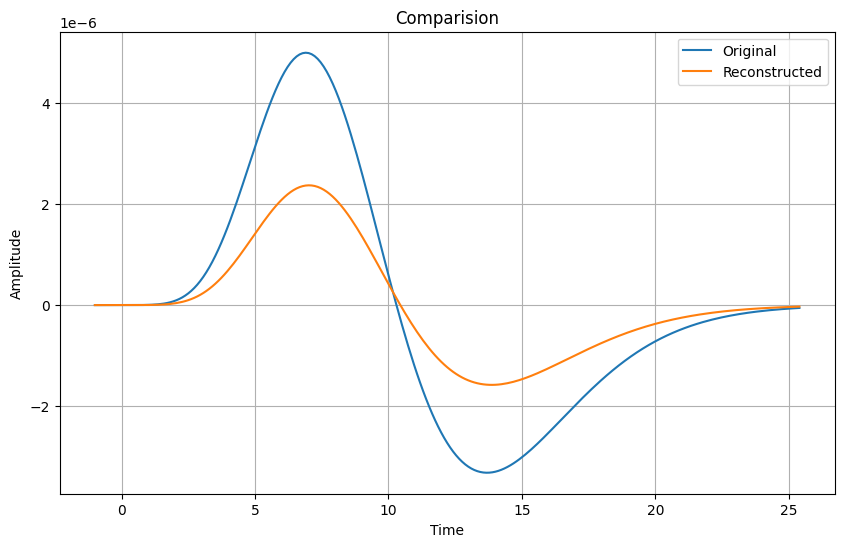

<Figure size 640x480 with 0 Axes>

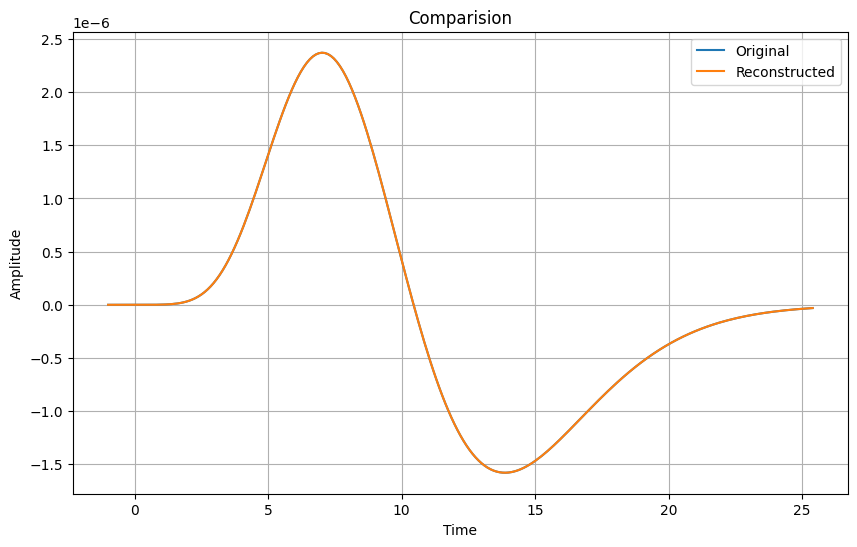

<Figure size 640x480 with 0 Axes>

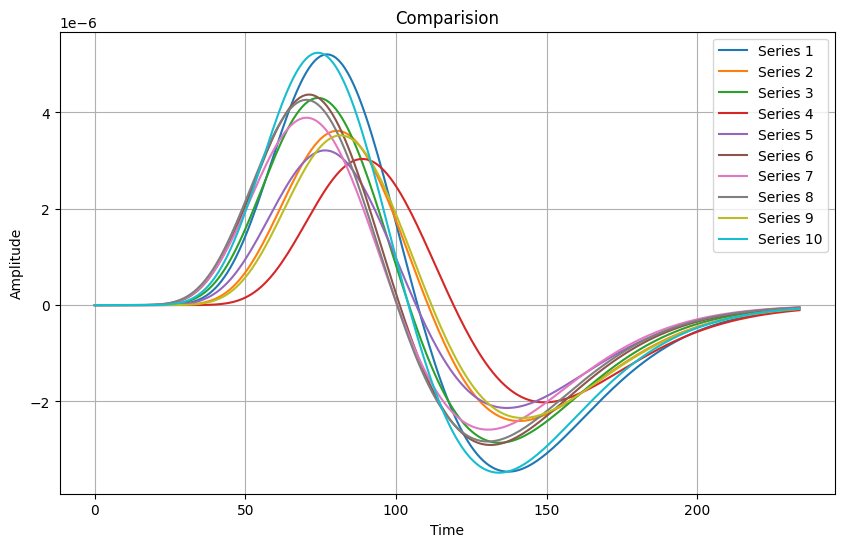

<Figure size 640x480 with 0 Axes>

In [263]:
# This is a demo of how data varies with generation.
displays.plot_comparision_data(generator.generate_hrf(time_signal, vary=True, shift_factor=0.1),generator.generate_hrf(time_signal), time_signal)
displays.plot_comparision_data(generator.generate_hrf(time_signal, vary=False),generator.generate_hrf(time_signal), time_signal)
displays.plot_many_comparision_series(generator.generate_hrf_set(10), time_signal)


In [247]:
# Actually generate, segment, etc... the data. (A demo to recreate my results)

# We're opting a 70%, 20%, 10% split on our data for training, validation and evaluation
# We also leave one final participant out to test on unseen participants
readings = real_haemo_data[:-1].flatten()

# We want a small subset to simulate the conditions an individual experiment, not focusing on 
# getting just resting state data, would have.
train_readings = real_haemo_data[:7].flatten() 
eval_readings = real_haemo_data[7: 9].flatten()
test_readings = real_haemo_data[-1].flatten()

real_data_overlays = return_rand_samples(train_readings, 1000, signal_length)
auto_data_overlays = return_seg_samples(generator.generate_auto_reg_noise(train_readings, 1000000), 235)
synt_data_overlays = generator.generate_synth_overlay(20000)
hrf_target_signals = generator.generate_hrf_set(5000)
print(f"Real samples: {np.shape(real_data_overlays)}, AutoReg samples: {np.shape(auto_data_overlays)}")
print(f"The number of generated_hrfs is {np.shape(hrf_target_signals)}")

Real samples: (1000, 235), AutoReg samples: (4255, 235)
The number of generated_hrfs is (235,)
